In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob
from utils import cal_PSNR,cal_SSIM

        

In [2]:
from CTImage import CTImage
from model import RED_CNN
from tqdm import tqdm


device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = RED_CNN().to(device)
model.load_state_dict(torch.load('./saved_file/ssim_model2_80.pth'))
ct_dataset = CTImage(patch_n=None,patch_size=None,root_dir='../data/TestSet')





def test(testset,save_file=False,batch_size=16):
    dataloader = DataLoader(testset,batch_size=16,shuffle=False)
    total_origin_PSNR = 0
    total_PSNR = 0
    total_origin_SSIM = 0
    total_SSIM = 0
    cnt = 0
    ToPIL = transforms.ToPILImage()
    with torch.no_grad():
        for _,batch in tqdm(enumerate(dataloader),total=len(dataloader)):
            targets = batch[1].to(device)
            inputs = batch[0].to(device)
            imgname = batch[2]
            #print(imgname)
            outputs = model(inputs).detach()
            for i in range(targets.shape[0]):
                total_origin_PSNR += cal_PSNR(inputs[i],targets[i])
                total_origin_SSIM += cal_SSIM(inputs[i],targets[i])
                total_PSNR += cal_PSNR(outputs[i],targets[i])
                total_SSIM += cal_SSIM(outputs[i],targets[i])
                if save_file:
                    rec_img = ToPIL(outputs[i])
                    filename = '.'.join(imgname[i].split('.')[:-1])+'_Rec.png'
                    rec_img.save('../res/'+filename)


            
            cnt += targets.shape[0]
    avg_origin_PSNR = total_origin_PSNR / cnt
    avg_origin_SSIM = total_origin_SSIM / cnt
    avg_PSNR = total_PSNR / cnt
    avg_SSIM = total_SSIM / cnt
    return avg_PSNR,avg_SSIM,avg_origin_PSNR,avg_origin_SSIM


In [19]:
PSNR,SSIM,_,_ = test(ct_dataset,save_file=True)
print('PSNR:{:.4f}'.format(PSNR))
print('SSIM:{:.4f}'.format(SSIM))

100%|██████████| 33/33 [01:04<00:00,  1.95s/it]

PSNR:40.7015
SSIM:0.9979


In [3]:
from thop import profile
input = torch.randn(1, 1, 256, 256).to(device)
macs, params = profile(model, inputs=(input, ))
print('GFLOPS:{}'.format(int(macs)>>29)) #flops = macs * 2 G = 2^30
print('params:{}'.format(params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
GFLOPS:205
params:1848865.0


In [4]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (1, 256, 256), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

RED_CNN(
  1.85 M, 100.000% Params, 110.19 GMac, 100.000% MACs, 
  (conv1): Conv2d(2.5 k, 0.135% Params, 158.51 MMac, 0.144% MACs, 1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(230.5 k, 12.467% Params, 14.18 GMac, 12.865% MACs, 96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(230.5 k, 12.467% Params, 13.72 GMac, 12.453% MACs, 96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(230.5 k, 12.467% Params, 13.28 GMac, 12.048% MACs, 96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(230.5 k, 12.467% Params, 12.84 GMac, 11.650% MACs, 96, 96, kernel_size=(5, 5), stride=(1, 1))
  (tconv1): ConvTranspose2d(230.5 k, 12.467% Params, 13.28 GMac, 12.048% MACs, 96, 96, kernel_size=(5, 5), stride=(1, 1))
  (tconv2): ConvTranspose2d(230.5 k, 12.467% Params, 13.72 GMac, 12.453% MACs, 96, 96, kernel_size=(5, 5), stride=(1, 1))
  (tconv3): ConvTranspose2d(230.5 k, 12.467% Params, 14.18 GMac, 12.865% MACs, 96, 96, kernel_size=(5, 5), stride=(1, 1))
  (tconv4): C

pred_psnr: 43.59227180480957
origin_psnr: 40.919766426086426
pred_ssim tensor(0.9983, device='cuda:0')
origin_ssim tensor(0.9966, device='cuda:0')


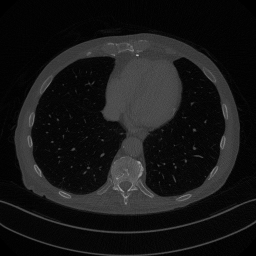

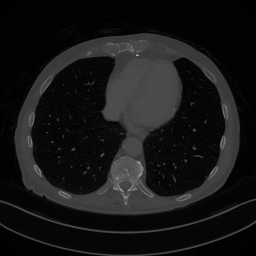

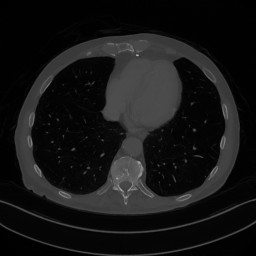

pred_psnr: 42.6379919052124
origin_psnr: 40.919766426086426
pred_ssim tensor(0.9978, device='cuda:0')
origin_ssim tensor(0.9966, device='cuda:0')


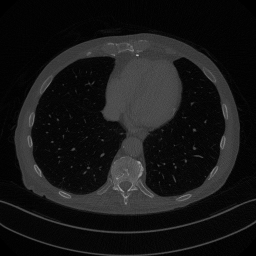

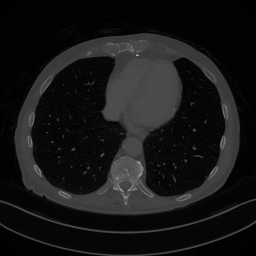

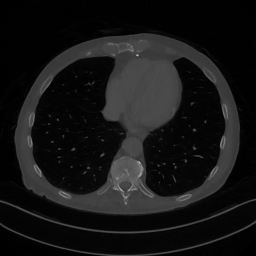

In [6]:
path = 'saved_file/ssim_model2_100.pth'
model.load_state_dict(torch.load(path))
dataset = CTImage(patch_n=None,patch_size=None,root_dir='../data/TestSet/')
example,target,_,__ = dataset[0]
example = example.to(device)
output = model(example).detach().to('cpu')

print('pred_psnr:',cal_PSNR(output[0].to(device),target[0].to(device)))
print('origin_psnr:',cal_PSNR(example[0].to(device),target[0].to(device)))
print('pred_ssim',cal_SSIM(output[0].to(device),target[0].to(device)))
print('origin_ssim',cal_SSIM(example[0].to(device),target[0].to(device)))
transform = transforms.ToPILImage()
example = transform(example[0])
target = transform(target[0])
res = transform(output[0])
example.show()
target.show()
res.show()


path = 'saved_file/model2_100.pth'
model.load_state_dict(torch.load(path))
example,target,_,__ = dataset[0]
example = example.to(device)
output = model(example).detach().to('cpu')

print('pred_psnr:',cal_PSNR(output[0].to(device),target[0].to(device)))
print('origin_psnr:',cal_PSNR(example[0].to(device),target[0].to(device)))
print('pred_ssim',cal_SSIM(output[0].to(device),target[0].to(device)))
print('origin_ssim',cal_SSIM(example[0].to(device),target[0].to(device)))
transform = transforms.ToPILImage()
example = transform(example[0])
target = transform(target[0])
res = transform(output[0])
example.show()
target.show()
res.show()